<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#What-is-a-Bayes-net?" data-toc-modified-id="What-is-a-Bayes-net?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>What is a Bayes net?</a></span></li><li><span><a href="#Representing-a-Bayes-net-in-code" data-toc-modified-id="Representing-a-Bayes-net-in-code-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Representing a Bayes net in code</a></span></li><li><span><a href="#Visualising-a-Bayes-net" data-toc-modified-id="Visualising-a-Bayes-net-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualising a Bayes net</a></span></li><li><span><a href="#Specifying-the-joint-probability-distribution-via-conditional-probabilities" data-toc-modified-id="Specifying-the-joint-probability-distribution-via-conditional-probabilities-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Specifying the joint probability distribution via conditional probabilities</a></span></li><li><span><a href="#Simulating-a-Bayes-net" data-toc-modified-id="Simulating-a-Bayes-net-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Simulating a Bayes net</a></span><ul class="toc-item"><li><span><a href="#Random-numbers" data-toc-modified-id="Random-numbers-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Random numbers</a></span></li><li><span><a href="#Representing-conditional-distributions" data-toc-modified-id="Representing-conditional-distributions-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Representing conditional distributions</a></span></li><li><span><a href="#Ordering-the-simulation-of-variables" data-toc-modified-id="Ordering-the-simulation-of-variables-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Ordering the simulation of variables</a></span></li><li><span><a href="#Simulating-independent-variables" data-toc-modified-id="Simulating-independent-variables-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Simulating independent variables</a></span></li><li><span><a href="#Simulating-conditional-variables" data-toc-modified-id="Simulating-conditional-variables-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Simulating conditional variables</a></span><ul class="toc-item"><li><span><a href="#Conditional-random-variates" data-toc-modified-id="Conditional-random-variates-5.5.1"><span class="toc-item-num">5.5.1&nbsp;&nbsp;</span>Conditional random variates</a></span></li><li><span><a href="#Actual-events" data-toc-modified-id="Actual-events-5.5.2"><span class="toc-item-num">5.5.2&nbsp;&nbsp;</span>Actual events</a></span></li><li><span><a href="#Multiply-and-row-sum" data-toc-modified-id="Multiply-and-row-sum-5.5.3"><span class="toc-item-num">5.5.3&nbsp;&nbsp;</span>Multiply and row-sum</a></span></li></ul></li><li><span><a href="#Combining-independent-and-conditional-variables" data-toc-modified-id="Combining-independent-and-conditional-variables-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Combining independent and conditional variables</a></span></li><li><span><a href="#Adding-non-events" data-toc-modified-id="Adding-non-events-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>Adding non-events</a></span></li></ul></li><li><span><a href="#Estimating-probabilities-from-a-Bayes-network" data-toc-modified-id="Estimating-probabilities-from-a-Bayes-network-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Estimating probabilities from a Bayes network</a></span><ul class="toc-item"><li><span><a href="#Approximating-P(X|Y)" data-toc-modified-id="Approximating-P(X|Y)-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Approximating P(X|Y)</a></span></li><li><span><a href="#Generalise-to-event-combinations" data-toc-modified-id="Generalise-to-event-combinations-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Generalise to event combinations</a></span></li></ul></li><li><span><a href="#Initialising-a-Bayes-net-from-user-input" data-toc-modified-id="Initialising-a-Bayes-net-from-user-input-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Initialising a Bayes net from user input</a></span><ul class="toc-item"><li><span><a href="#Parsing-key-info-from-CSV" data-toc-modified-id="Parsing-key-info-from-CSV-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Parsing key info from CSV</a></span></li><li><span><a href="#Parsing-conditional-distributions-from-CSV" data-toc-modified-id="Parsing-conditional-distributions-from-CSV-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Parsing conditional distributions from CSV</a></span></li><li><span><a href="#Checking-for-self-consistency" data-toc-modified-id="Checking-for-self-consistency-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Checking for self-consistency</a></span></li><li><span><a href="#Re-write-BayesNet-class" data-toc-modified-id="Re-write-BayesNet-class-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Re-write BayesNet class</a></span></li></ul></li><li><span><a href="#Structuring-Python-code" data-toc-modified-id="Structuring-Python-code-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Structuring Python code</a></span></li></ul></div>

# What is a Bayes net?

A Bayes net - or Bayesian network - is a probabilistic graphical model, or PGM. It is a simple and intuitive way to represent a joint probability distribution by specifying conditional probability distributions for the underlying variables in the network. Bayes nets can represent both discrete and continuous variables. For this project we will focus on networks with discrete, binary variables. 

However we will endeavour to keep the implementation generic such that extension to general discrete variable and continuous variable networks is possible. Comments are added where this informs design decisions, and we also consider extensions to the code.

We'll use a popular toy example to explore the implementation, the alarm network: https://github.com/jpmcarrilho/AIMA/blob/master/probability-4e.ipynb 

_The story, from Judea Pearl, is that there is a house burglar alarm, which can be triggered by either a burglary or an earthquake. If the alarm sounds, one or both of the neighbors, John and Mary, might call the owner to say the alarm is sounding._

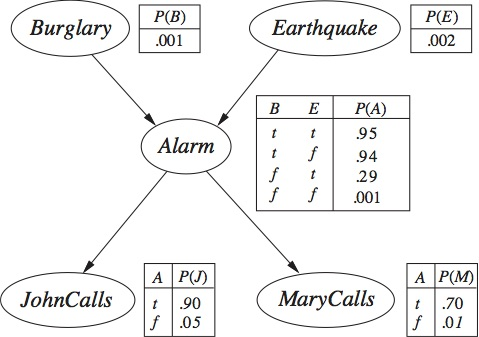

In [127]:
# delete all variables before we run any code - they linger!
# add libraries for the jupyter extensions
import json
import autopep8
%reset - f

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  -, please run `%reset?` for details
Don't know how to reset  f, please run `%reset?` for details


# Representing a Bayes net in code

Conceptually a Bayes net is simple; all we need is the node mappings, or dependencies, and the probabilities that define the conditional / unconditional probability distributions. In terms of defining a structure, we will look to capture the key attributes.

|Attribute |Description| 
|-----|-----|
| _names_ |Maps a convenient shorthand node label to the to the full text e.g. A for Alarm  |
| _names_ |Maps nodes to the variable distribution |
|_dependencies_|Maps nodes to their dependents |
|_parents_|Maps nodes to their parents |
|_conditional_probabilities_|Maps nodes to their conditional probabilities |
|_all_nodes_|Set of all nodes |
|_independent_nodes_|Set of nodes with no parents |
|_leaf_nodes_|Set of nodes with no dependencies |

We use a dataclass to represent this structure.

In [128]:
from dataclasses import dataclass


@dataclass
class BayesNet:
    """Class for representing a Bayes net."""
    names: dict
    distributions: dict
    dependencies: dict
    parents: dict
    conditional_probabilities: dict
    all_nodes: set
    independent_nodes: set
    leaf_nodes: set

We construct the network manually; later we generalise the process such that the object can be initialised from a minimal representation.

In [129]:
bayesnet_alarm = BayesNet(names={
    'B': 'Burglary',
    'E': 'Earthquake',
    'A': 'Alarm',
    'M': 'Mary calls',
    'J': 'John calls'
},
    distributions={
    'B': 'TBC',
    'E': 'TBC',
    'A': 'TBC',
    'M': 'TBC',
    'J': 'TBC'
},
    dependencies={
    'B': ['A'],
    'E': ['A'],
    'A': ['M', 'J']
},
    parents={
    'M': ['A'],
    'J': ['A'],
    'A': ['B', 'E']
},
    conditional_probabilities=None,
    all_nodes={'B', 'E', 'A', 'M', 'J'},
    independent_nodes={'B', 'E'},
    leaf_nodes={'M', 'J'})

# Visualising a Bayes net

Seeing a network makes it easier to interpret. The package graphviz is a great tool; all we need to do is specify the nodes, and the edges between nodes, which we can extract from the attributes. We can add as much or as little information as we like to the nodes and edges, for example simulation output and conditional probabilities. For the moment we just visualise the dependencies.

__Note__ - the code to visualise the Bayes net is replaced here with the image. This works with the ipykernel, but using the virtual environment encounters this issue: _ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH_ On the list to fix.

In [130]:
import graphviz


def visualise_bn(bn: BayesNet, use_full_names: bool):
    """Visualises Bayes net object."""
    g = graphviz.Digraph()
    for node, next_nodes in bn.dependencies.items():
        for nn in next_nodes:
            if use_full_names:
                g.edge(bn.names[node], bn.names[nn])
            else:
                g.edge(node, nn)
    return g

In [131]:
# visualise_bn(bn=bayesnet_alarm, use_full_names=True)

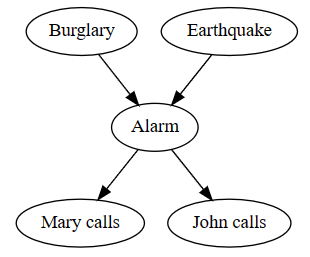

# Specifying the joint probability distribution via conditional probabilities

The tricky bit of a Bayes net is how to succinctly and efficiently represent and work with the conditional probabilities. We can use a CSV format to specify the key information, which we have done for the alarm network: [data/conditional_probabilities_alarm.csv](../data/conditional_probabilities_alarm.csv).

We read these into a Pandas data-frame. Each distribution is specified on one row. For independent nodes - B & E - there is no conditioning, hence one line defines the complete and unconditional probability. A requires four rows, since it has two parent nodes, each of which can take two values. J and M each have one parent, so require two rows.

The parameter naming convention is consistent with the distributions in scipy.stats, which we will use for the simulation of the network.

In [132]:
import pandas as pd


with open('../data/conditional_probabilities_alarm.csv', 'r') as f:
    conditional_probabilities_df_alarm = pd.read_csv(f, na_filter=False)

conditional_probabilities_df_alarm

,node,distribution,parameters,conditionals
0,B,BERNOULLI,p=0.001,None
1,E,BERNOULLI,p=0.002,None
2,A,BERNOULLI,p=0.95,B=1;E=1
3,A,BERNOULLI,p=0.94,B=1;E=0
4,A,BERNOULLI,p=0.29,B=0;E=1
5,A,BERNOULLI,p=0.001,B=0;E=0
6,J,BERNOULLI,p=0.9,A=1
7,J,BERNOULLI,p=0.05,A=0
8,M,BERNOULLI,p=0.7,A=1
9,M,BERNOULLI,p=0.01,A=0


# Simulating a Bayes net

As with many topics there are two parts to being able to code the simulation part of a Bayes net:
1. Understanding the concepts independent of code
2. Implementing the concepts once you understood them

To understand the concepts I found it easier to build an excel model first: [excel/bayes_net_alarm.xlsx](../excel/bayes_net_alarm.xlsx). This gave decent insight into the key elements, and made the subsequent coding easier. The Excel model is a good roadmap for the content in this section.

## Random numbers

Stochastic models can be difficult to test if the randomness is implicit and embedded within the model. In the spirit of _Explicit is better than implicit_, we separate the random numbers from the functions that simulate the random variates. Then the simulation functions are deterministic and more amenable to testing.

The format of random numbers for the Bayes net is a data-frame where each node maps to N random numbers on [0,1]. Generally we would use a single seed to generate the array. Here - for the purposes of testing - we read in an array from CSV that can be used in the Excel model. This gives us a sensible overall test that the model is implemented consistently in Python and Excel.


In [133]:
with open('../excel/fixed_random_numbers_100k.csv', 'r') as f:
    random_numbers = pd.read_csv(f)
N = random_numbers.shape[0]

random_numbers = 1 - random_numbers  # to align Excel and ppf, since Excel tests lower tail
random_numbers.head()

,B,E,A,M,J
0,0.946102,0.578330,0.741226,0.365127,0.833227
1,0.998269,0.157830,0.723855,0.279586,0.861028
2,0.537858,0.691179,0.728596,0.346864,0.346127
3,0.420817,0.045270,0.658436,0.841218,0.978299
4,0.762577,0.817734,0.442690,0.748229,0.558408


## Representing conditional distributions

Earlier we set out a minimal view of the conditional distributions in a CSV file. We're now at the point where we can set out a comparable representation in code; we'll combine the two later on when we write a basic parse function to read the CSV and generate the objects.

As for the Bayes net we use a dataclass. The attributes are aligned to the CSV content, with two exceptions. Since a given node in general maps to more than one conditional distribution, we use the __node__ as a key mapping to a list of objects. This gives a little more structure vs. a flat list of objects linked by attribute

Given an input on [0,1], the conditional distribution needs to invert the CDF and return a value; we use the percentile-point function (__ppf__) for the distributions in the scipy.stats library (for Bernoulli nodes we also convert the result to an int to make comparisons unambiguous). Partial-function application embeds the distribution and parameter(s) and simplifies the function call while retaining the information as attributes. By hand this duplicates information - e.g. p - and is error-prone, but this is illustrative only until we set out a minimal parse function.

An enumeration is added for the distribution. There's only one at present, but it's useful structure for extending the code to multiple distributions.

In [134]:
from enum import Enum
from typing import Callable


class Distribution(Enum):
    BERNOULLI = 1


distribution_to_possible_values = {
    Distribution.BERNOULLI: [0, 1]
}


@dataclass
class ConditionalDistribution:
    """Class for representing a conditional distribution."""
    distribution: Distribution
    parameters: dict
    conditionals: [tuple]
    ppf: Callable

In [135]:
from scipy.stats import bernoulli

conditional_distributions = {
    'B': [
        ConditionalDistribution(distribution=Distribution.BERNOULLI,
                                parameters={'p': 0.001},
                                conditionals=None,
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.001)).astype(int))
    ],
    'E': [
        ConditionalDistribution(distribution=Distribution.BERNOULLI,
                                parameters={'p': 0.002},
                                conditionals=None,
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.002)).astype(int))
    ],
    'A': [
        ConditionalDistribution(distribution=Distribution.BERNOULLI,
                                parameters={'p': 0.001},
                                conditionals=[('B', 0), ('E', 0)],
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.001)).astype(int)),
        ConditionalDistribution(distribution=Distribution.BERNOULLI,
                                parameters={'p': 0.29},
                                conditionals=[('B', 0), ('E', 1)],
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.29)).astype(int)),
        ConditionalDistribution(distribution=Distribution.BERNOULLI,
                                parameters=[('p', 0.94)],
                                conditionals=[('B', 1), ('E', 0)],
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.94)).astype(int)),
        ConditionalDistribution(distribution=Distribution.BERNOULLI,
                                parameters={'p': 0.95},
                                conditionals=[('B', 1), ('E', 1)],
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.95)).astype(int))
    ],
    'M': [
        ConditionalDistribution(distribution=Distribution.BERNOULLI,
                                parameters={'p': 0.01},
                                conditionals=[('A', 0)],
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.01)).astype(int)),
        ConditionalDistribution(distribution=Distribution.BERNOULLI,
                                parameters={'p': 0.7},
                                conditionals=[('A', 1)],
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.7)).astype(int))
    ],
    'J': [
        ConditionalDistribution(distribution=Distribution.BERNOULLI,
                                parameters={'p': 0.05},
                                conditionals=[('A', 0)],
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.05)).astype(int)),
        ConditionalDistribution(distribution=Distribution.BERNOULLI,
                                parameters={'p': 0.9},
                                conditionals=[('A', 1)],
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.9)).astype(int))
    ]
}

## Ordering the simulation of variables

Intuitively we know how to simulate the nodes in the alarm network: B and E followed by A, then M and J. With this ordering we know the conditional variable values as required when we get to a node with parents. In general, especially for larger networks, we cannot do this by hand. 

The function below creates a valid ordering. May be a better way to do this....! Print statements added for clarity.

In [136]:
from copy import deepcopy


def generate_simulation_order(bn: BayesNet):
    # use three lists - indepedent nodes, conditional nodes, order
    # order is initially empty while conditional and independent nodes are initialised from network values
    # while independent nodes not empty:
    #     pop off node and append to order - return if no conditionals left
    #     remove node from any parent mapping
    #     evaluate whether any conditional nodes are now (conditionally) independent
    #     append these to independent nodes
    # when setting the original lists, apply sort to allow reproducibility
    independent_nodes = list(bn.independent_nodes)
    conditional_nodes = list(bn.all_nodes - bn.independent_nodes)
    parents = deepcopy(bn.parents)
    node_order = []
    while independent_nodes:
        print(f'{independent_nodes}:{conditional_nodes}:{node_order}')
        node = independent_nodes.pop()
        print(f'popped off {node}')
        node_order.append(node)
        print(f'{independent_nodes}:{conditional_nodes}:{node_order}')

        print(f'can we remove parent {node} from {parents}?')
        for c, ps in parents.items():
            if node in ps:
                ps.remove(node)
        print(f'post-update parents is {parents}')

        print(f'are there any newly (conditionally) independent nodes?')
        conditionally_independent_nodes = sorted(
            [c for c, ps in parents.items() if ps == []])
        for c in conditionally_independent_nodes:
            parents.pop(c)
            conditional_nodes.remove(c)
        print(f'{conditionally_independent_nodes}\n')
        if conditionally_independent_nodes:
            independent_nodes = independent_nodes + conditionally_independent_nodes

    return node_order


simulation_order = generate_simulation_order(bayesnet_alarm)

['B', 'E']:['M', 'A', 'J']:[]
popped off E
['B']:['M', 'A', 'J']:['E']
can we remove parent E from {'M': ['A'], 'J': ['A'], 'A': ['B', 'E']}?
post-update parents is {'M': ['A'], 'J': ['A'], 'A': ['B']}
are there any newly (conditionally) independent nodes?
[]

['B']:['M', 'A', 'J']:['E']
popped off B
[]:['M', 'A', 'J']:['E', 'B']
can we remove parent B from {'M': ['A'], 'J': ['A'], 'A': ['B']}?
post-update parents is {'M': ['A'], 'J': ['A'], 'A': []}
are there any newly (conditionally) independent nodes?
['A']

['A']:['M', 'J']:['E', 'B']
popped off A
[]:['M', 'J']:['E', 'B', 'A']
can we remove parent A from {'M': ['A'], 'J': ['A']}?
post-update parents is {'M': [], 'J': []}
are there any newly (conditionally) independent nodes?
['J', 'M']

['J', 'M']:[]:['E', 'B', 'A']
popped off M
['J']:[]:['E', 'B', 'A', 'M']
can we remove parent M from {}?
post-update parents is {}
are there any newly (conditionally) independent nodes?
[]

['J']:[]:['E', 'B', 'A', 'M']
popped off J
[]:[]:['E', 'B',

Test this on a minimal example of 3 nodes - A, B, C - with A mapping to both, and B also mapping to C. There is one valid ordering: A, B, C. Proxy the BayesNet argument with a namedtuple that has the required attributes.

In [137]:
from collections import namedtuple
BayesNetLight = namedtuple(
    'BayesNetLight', 'independent_nodes all_nodes parents')

assert (generate_simulation_order(BayesNetLight(
    {'A'}, {'A', 'B', 'C'}, {'B': ['A'], 'C': ['A', 'B']})) == ['A', 'B', 'C'])

['A']:['B', 'C']:[]
popped off A
[]:['B', 'C']:['A']
can we remove parent A from {'B': ['A'], 'C': ['A', 'B']}?
post-update parents is {'B': [], 'C': ['B']}
are there any newly (conditionally) independent nodes?
['B']

['B']:['C']:['A']
popped off B
[]:['C']:['A', 'B']
can we remove parent B from {'C': ['B']}?
post-update parents is {'C': []}
are there any newly (conditionally) independent nodes?
['C']

['C']:[]:['A', 'B']
popped off C
[]:[]:['A', 'B', 'C']
can we remove parent C from {}?
post-update parents is {}
are there any newly (conditionally) independent nodes?
[]



## Simulating independent variables

Independent variables can be simulated directly. We use the percentile-point function of the object to map the random number input into random variates of 1 and 0; these represent instances of where the variable has (1) or has not occurred (0).

We can demo this for the variables B and E. Starting with an empty dataframe, we iterate over the independent variables and join the output into a single dataframe.

In [138]:
random_variates = pd.DataFrame()
for var in ['B', 'E']:
    if len(conditional_distributions[var]) == 1:
        # no condtionals, append to existing output
        random_variates = pd.concat([
            random_variates,
            pd.DataFrame({
                var:
                conditional_distributions[var][0].ppf(random_numbers[var])
            })
        ],
            axis=1)
    else:
        # to be defined
        pass

random_variates

,B,E
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
99995,0,0
99996,0,0
99997,0,0
99998,0,0


Due to the low probabilities that a burglary or earthquake occurs, the arrays are mostly zeros. We can sense check that the results are correct by summing the arrays. Given probabilities of 0.1% and 0.2%, respectively, for burglaries and earthquakes, we would expect sums of close to 100 and 200.

In [139]:
random_variates.sum()

B     91
E    194
dtype: int64

## Simulating conditional variables

Simulating conditional variables is a little more involved. We apply a two step approach, where we simluate conditional distributions as we did for the independent variables, but also use simulate the actual events. The latter requires the random variates constructed to date. 

We will demo this with the alarm variable, A.

In [140]:
var = 'A'

### Conditional random variates

Create a Pandas dataframe for each conditional distribution, using the list of conditionals as the column keys. There are lots of 1s, which indicate the alarm going off, but these are contingent on one or both of a burglary or earthquake occurring. 

In [141]:
conditional_random_variates = pd.concat([
    pd.DataFrame({str(cd.conditionals): cd.ppf(random_numbers[var])})
    for cd in conditional_distributions[var]
],
    axis=1)

conditional_random_variates

,"[('B', 0), ('E', 0)]","[('B', 0), ('E', 1)]","[('B', 1), ('E', 0)]","[('B', 1), ('E', 1)]"
0,0,1,1,1
1,0,1,1,1
2,0,1,1,1
3,0,0,1,1
4,0,0,1,1
...,...,...,...,...
99995,0,0,1,1
99996,0,0,1,1
99997,0,0,1,1
99998,0,0,1,1


In [142]:
conditional_random_variates.sum()

[('B', 0), ('E', 0)]      107
[('B', 0), ('E', 1)]    29109
[('B', 1), ('E', 0)]    94086
[('B', 1), ('E', 1)]    95103
dtype: int64

### Actual events

Use the same format - a Pandas dataframe with the conditionals as column keys - to create the array of actual events. This is again a series of 1s and 0s, but these represent whether a conditional event has occurred. e.g. whether there has been no burglary and no earthquake.

For this purpose we first define a separate function to generate the actual events.

In [143]:
import numpy as np


def generate_actual_events(conditionals: [tuple],
                           random_variates: pd.DataFrame) -> np.array:
    """
    Given a list of conditional (variable, value) pairs and a dataframe of random variates (1s and 0s),
    this function generates flags for whether the conditional is met
    e.g. given [('B', 0),('E', 0)], the return value is 1 where B and E are 0, and 0 elsewhere.

    Return Numpy array of 1s and 0s.
    """
    number_conditionals = len(conditionals)
    number_variates = random_variates.shape[0]
    outcomes = np.zeros((number_variates, number_conditionals)).astype(int)
    for i, (variable, value) in enumerate(conditionals):
        outcomes[:, i] = (random_variates[variable] == value) * 1

    return np.product(outcomes, axis=1)


assert np.all(
    generate_actual_events(conditionals=[('B', 0), ('E', 0)],
                           random_variates=pd.DataFrame({
                               'B': [0, 0, 1, 1],
                               'E': [0, 1, 0, 1]
                           })) == np.array([1, 0, 0, 0]))

Now apply the same pattern as before.

In [144]:
actual_events = pd.concat([
    pd.DataFrame({
        str(cd.conditionals):
        generate_actual_events(cd.conditionals, random_variates)
    }) for cd in conditional_distributions[var]
],
    axis=1)

actual_events

,"[('B', 0), ('E', 0)]","[('B', 0), ('E', 1)]","[('B', 1), ('E', 0)]","[('B', 1), ('E', 1)]"
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
99995,1,0,0,0
99996,1,0,0,0
99997,1,0,0,0
99998,1,0,0,0


The count of actual events is another sense check. 99.7% of the time there is no burglary or earthquake.

In [145]:
actual_events.sum()

[('B', 0), ('E', 0)]    99715
[('B', 0), ('E', 1)]      194
[('B', 1), ('E', 0)]       91
[('B', 1), ('E', 1)]        0
dtype: int64

###  Multiply and row-sum

The final step is to multiply then row-sum the two dataframes together. Multiplying the two together gives the random variates for the variable, in this case the alarm, A. It is no longer conditional, since the actual events have acted as a filter, by zeroising all but one entry. It can be a little confusing that the entry which is not zeroised, may also be zero.

Applying a row-sum returns this as the simulated value for A. We can then join this to the independent random variates already created for B and E.

In [146]:
random_variates_A = pd.DataFrame(
    {'A': (conditional_random_variates * actual_events).sum(axis=1)})
random_variates = pd.concat([random_variates, random_variates_A], axis=1)
random_variates.sum()

B     91
E    194
A    250
dtype: int64

## Combining independent and conditional variables

Now we can simulate both variable types together.

In [147]:
def simulate_bayes_net(simulation_order: list, conditional_distributions: [ConditionalDistribution], random_numbers: np.ndarray):
    """Simulates Bayes net to produce data-frame of random variates."""
    random_variates = pd.DataFrame()
    for var in simulation_order:
        if len(conditional_distributions[var]) == 1:
            # no condtionals, append to existing output
            random_variates = pd.concat([
                random_variates,
                pd.DataFrame({
                    var:
                    conditional_distributions[var][0].ppf(random_numbers[var])
                })
            ],
                axis=1)
        else:
            conditional_random_variates = pd.concat([
                pd.DataFrame(
                    {str(cd.conditionals): cd.ppf(random_numbers[var])})
                for cd in conditional_distributions[var]
            ],
                axis=1)

            actual_events = pd.concat([
                pd.DataFrame({
                    str(cd.conditionals):
                    generate_actual_events(cd.conditionals, random_variates)
                }) for cd in conditional_distributions[var]
            ],
                axis=1)

            random_variates = pd.concat([
                random_variates,
                pd.DataFrame({
                    var: (conditional_random_variates *
                          actual_events).sum(axis=1)
                })
            ],
                axis=1)

    return random_variates


random_variates = simulate_bayes_net(
    simulation_order, conditional_distributions, random_numbers)
random_variates.sum()

E     194
B      91
A     250
M    1191
J    5120
dtype: int64

We can test this vs. Excel output.

In [148]:
with open('../excel/random_variate_excel_100k.csv', 'r') as f:
    random_variates_excel = pd.read_csv(f)

# columns in arrays may be ordered differently
# iterate through columns and compare
for col in simulation_order:
    print(f'comparing: {col}')
    assert (np.all(random_variates[col] == random_variates_excel[col]))

comparing: E
comparing: B
comparing: A
comparing: M
comparing: J


## Adding non-events

What can be useful to consider is non-events e.g. the event that an earthquake did not happen. Given the random variates output, this is straightforward. This is not restricted to binary outcomes and can be applied to any variable with a discrete number of outcomes. However, the snippet below is only applicable for variables with values 0 or 1.

In [149]:
random_variates_negation = random_variates.copy()
random_variates_negation.columns = [
    '¬' + x for x in random_variates_negation.columns
]
random_variates_negation = 1 - random_variates_negation

random_variates = pd.concat([random_variates, random_variates_negation],
                            axis=1)
random_variates.sum()

E       194
B        91
A       250
M      1191
J      5120
¬E    99806
¬B    99909
¬A    99750
¬M    98809
¬J    94880
dtype: int64

# Estimating probabilities from a Bayes network

Small Bayes nets can be solved by hand to give the joint probability distribution - in this case the probabilities of each event - and also the conditional probabilities of one event given another. This extends beyond the conditional probabilities input, and allows us to answer questions like: _given that John and Mary called, what is the probability that a burglary or earthquake occurred?_

For larger Bayes nets, and/or for convenience, simulation allows us to approximate these probabilities. 

## Approximating P(X|Y)

The random variate output contains simulated output for each of the variables in the network, and also the non-events. With 10 variables this gives 100 (X,Y) events, since the order matters.

In [150]:
all_vars = random_variates.columns
count_x_and_y = {}
count_y = {}
for y in all_vars:
    count_y[y] = random_variates[y].sum()
    for x in all_vars:
        count_x_and_y[(x, y)] = (random_variates[x] * random_variates[y]).sum()

full_names = {
    'B': 'Burglary',
    'E': 'Earthquake',
    'A': 'Alarm',
    'M': 'Mary calls',
    'J': 'John Calls',
    '¬B': 'No burglary',
    '¬E': 'No earthquake',
    '¬A': 'No alarm',
    '¬M': 'Mary does not call',
    '¬J': 'John does not call'
}

summary_probabilities_df = pd.concat([
    pd.DataFrame(
        {
            'Label': f'P({x}|{y})',
            'Event X': full_names[x],
            'Event Y': full_names[y],
            'Count X & Y': cxy,
            'Count Y': count_y[y],
            'Estimate for P(X|Y)': cxy / count_y[y]
        },
        index=[0]) for ((x, y), cxy) in count_x_and_y.items()
])

summary_probabilities_df.set_index('Label', inplace=True)

Should the homeowner be concerned about a burglary or an earthquake if Mary or John call? Not hugely. Note this doesn't yet answer the quesiton: _given that John and Mary called, what is the probability that a burglary or earthquake occurred?_ For that we consider event combinations.

In [151]:
summary_probabilities_df.loc[['P(B|M)', 'P(E|M)', 'P(B|J)', 'P(E|J)'], :]

,Event X,Event Y,Count X & Y,Count Y,Estimate for P(X|Y)
Label,,,,,
P(B|M),Burglary,Mary calls,52,1191,0.043661
P(E|M),Earthquake,Mary calls,44,1191,0.036944
P(B|J),Burglary,John Calls,78,5120,0.015234
P(E|J),Earthquake,John Calls,62,5120,0.012109


Split this code into two functions, one that calculates the counts for a given event - and is more amenable to testing - and a second one that generates a user-friendly output. The counts are important to return since they give context for how credible the estimate is i.e. the more events, the more credible. Note this function is only valid for nets with binary variables.

In [152]:
def estimate_p_x_y(random_variates: pd.DataFrame,
                   x: str,
                   y: str):
    """Estimates P(X|Y) from counts."""
    count_y = random_variates[y].sum()
    count_x_and_y = (random_variates[x] * random_variates[y]).sum()

    return (count_x_and_y, count_y, count_x_and_y / count_y)

In [153]:
def generate_p_x_y_df(random_variates: pd.DataFrame, names: dict):
    """Generates data-frame of P(X|Y): counts and empirical probabilities."""
    count_x_and_y = {}
    count_y = {}
    for y in names:
        count_y[y] = random_variates[y].sum()
        for x in names:
            count_x_and_y[(x, y)] = (random_variates[x]
                                     * random_variates[y]).sum()

    p_x_y_df = pd.concat([
        pd.DataFrame(
            {
                'Label': f'P({x}|{y})',
                'Event X': names[x],
                'Event Y': names[y],
                'Count X & Y': cxy,
                'Count Y': count_y[y],
                'Estimate for P(X|Y)': cxy / count_y[y]
            },
            index=[0]) for ((x, y), cxy) in count_x_and_y.items()
    ])
    p_x_y_df.set_index('Label', inplace=True)

    return p_x_y_df

## Generalise to event combinations

Given a list of events, there are different combinations we can consider:
- all events occur
- any event occurs
- no event occurs

It's convenient to represent this as an enumeration.

In [154]:
class EventCombination(Enum):
    ALL_EVENTS = 1
    ANY_EVENT = 2
    NO_EVENTS = 3

We can write a function to generate a new variable array based on:
- existing random variate output
- an event combination, and
- a list of (variable, event) pairs

This returns the event in a slightly different format i.e. a Numpy array vs. a Pandas data-frame. This is mainly for convenience - easier to do calcs on Numpy arrays - and since this functionality will be called from within another function - essentially hidden - to calculate P(X|Y), where X and Y are generalised combinations.

In [155]:
def generate_new_event(random_variates: pd.DataFrame,
                       ec: EventCombination,
                       variables_events: [tuple]):
    """Generate new event array based on specified list of (variable,event) pairs and a combination (all, any, no)."""
    num_events = len(variables_events)
    event_array = np.column_stack(
        [np.array((random_variates[v] == e).astype(int)) for v, e in variables_events])
    event_array_sum = event_array.sum(axis=1)

    if ec == EventCombination.ALL_EVENTS:
        return (event_array_sum == num_events).astype(int)
    elif ec == EventCombination.ANY_EVENT:
        return (event_array_sum > 0).astype(int)
    elif ec == EventCombination.NO_EVENTS:
        return (event_array_sum == 0).astype(int)
    else:
        raise AssertionError(
            f'Invalid input: {ec} - expected valid EventCombination input')

Now write a second function which, given two event combinations, generates the underlying events and then estimates the probability P(X|Y).

In [156]:
def estimate_p_x_y_generalised(random_variates: pd.DataFrame,
                               ec_x: EventCombination,
                               variables_events_x: [tuple],
                               ec_y: EventCombination,
                               variables_events_y: [tuple]):
    """Estimates P(X|Y) for generalised events X,Y."""
    event_x = generate_new_event(random_variates, ec_x, variables_events_x)
    event_y = generate_new_event(random_variates, ec_y, variables_events_y)
    event_x_and_y = event_x * event_y

    count_y = event_y.sum()
    count_x_and_y = event_x_and_y.sum()

    return (count_x_and_y, count_y, count_x_and_y / count_y)

Test this is valid by checking this vs. the non-generalised version for single events. 

In [157]:
for y in all_vars:
    for x in all_vars:
        p_x_y_1 = estimate_p_x_y(random_variates, x, y)
        p_x_y_2 = estimate_p_x_y_generalised(random_variates,
                                             EventCombination.ALL_EVENTS, [
                                                 (x, 1)],
                                             EventCombination.ALL_EVENTS, [(y, 1)])
        assert (p_x_y_1 == p_x_y_2)

Now we can answer the question: _given that John and Mary called, what is the probability that a burglary or earthquake occurred?_ Close to a coin toss; the fact that both neighbours called should be noted!

In [158]:
estimate_p_x_y_generalised(random_variates,
                           EventCombination.ANY_EVENT, [('B', 1), ('E', 1)],
                           EventCombination.ALL_EVENTS, [('M', 1), ('J', 1)])

(87, 202, 0.4306930693069307)

# Initialising a Bayes net from user input

Earlier we set out a minimal representation of the alarm network in a CSV file. This network is small enough that we can set it out by hand. If it's much bigger that becomes difficult. We would like the user to be able to specify their own Bayes net. We can do this in three stages.

1. parse the key info supplied via CSV
2. parse the conditional distributions via CSV
3. check that (1) and (2) are self-consistent


## Parsing key info from CSV

Aside from the conditional probabilities, the Bayes net has the following attributes:
- names
- distributions
- dependencies
- parents
- all_nodes
- independent_nodes
- leaf_nodes

There is redundancy here. For example, while it's useful to have the parents and dependencies available separately, we can always infer one from the other. With this in mind, we create a CSV file that contains the minimal information required (names, distributions, dependencies): [../data/summary_alarm.csv](data/summary_alarm.csv). Read this in and view the content.

In [159]:
with open('../data/summary_alarm.csv', 'r') as f:
    summary_df_alarm = pd.read_csv(f, na_filter=False)

summary_df_alarm

,node,name,distribution,dependencies
0,B,Burglary,BERNOULLI,A
1,E,Earthquake,BERNOULLI,A
2,A,Alarm,BERNOULLI,M;J
3,M,Mary calls,BERNOULLI,None
4,J,John calls,BERNOULLI,None


In [160]:
def parse_summary(summary_df: pd.DataFrame):
    """Parse summary info for Bayes net."""

    # assert nodes unique and get all nodes
    assert (summary_df['node'].is_unique)
    all_nodes = set(summary_df['node'])

    # get names
    names = dict(zip(summary_df['node'], summary_df['name']))

    # get distributions
    # output meaningful error message if this fails
    try:
        distributions_enumd = [getattr(Distribution, d)
                               for d in summary_df['distribution']]
        distributions = dict(zip(summary_df['node'], distributions_enumd))
    except:
        raise AssertionError(
            f'Invalid distribution selected. Valid choices are: {[d.name for d in Distribution]}')

    # get dependencies
    dependencies = {}
    for i, row in summary_df.iterrows():
        if row.dependencies == 'None':
            dependencies[row.node] = []
        else:
            dependencies[row.node] = row.dependencies.split(';')
    dependencies = {c: p for c, p in dependencies.items() if p != []}

    # extract parents from dependencies
    parents = {node: [] for node in all_nodes}
    for c, ps in dependencies.items():
        if ps is not None:
            for p in ps:
                parents[p].append(c)
    parents = {p: c for p, c in parents.items() if c != []}

    # get independent and leaf nodes as implied from parents and dependencies
    independent_nodes = {node for node in all_nodes if node not in parents}
    leaf_nodes = {node for node in all_nodes if node not in dependencies}

    return (all_nodes, names, distributions, dependencies, parents, independent_nodes, leaf_nodes)


all_nodes, names, distributions, dependencies, parents, independent_nodes, leaf_nodes = parse_summary(
    summary_df_alarm)
print(f'all_nodes: {all_nodes}\n')
print(f'names: {names}\n')
print(f'distributions: {distributions}\n')
print(f'dependencies: {dependencies}\n')
print(f'parents: {parents}\n')
print(f'independent_nodes: {independent_nodes}\n')
print(f'leaf_nodes: {leaf_nodes}')

all_nodes: {'B', 'J', 'M', 'A', 'E'}

names: {'B': 'Burglary', 'E': 'Earthquake', 'A': 'Alarm', 'M': 'Mary calls', 'J': 'John calls'}

distributions: {'B': <Distribution.BERNOULLI: 1>, 'E': <Distribution.BERNOULLI: 1>, 'A': <Distribution.BERNOULLI: 1>, 'M': <Distribution.BERNOULLI: 1>, 'J': <Distribution.BERNOULLI: 1>}

dependencies: {'B': ['A'], 'E': ['A'], 'A': ['M', 'J']}

parents: {'J': ['A'], 'M': ['A'], 'A': ['B', 'E']}

independent_nodes: {'B', 'E'}

leaf_nodes: {'M', 'J'}


## Parsing conditional distributions from CSV

We read in the CSV earlier. Let's do that again and re-acquaint ourselves with the format.

In [161]:
import pandas as pd


with open('../data/conditional_probabilities_alarm.csv', 'r') as f:
    conditional_probabilities_df_alarm = pd.read_csv(f, na_filter=False)

conditional_probabilities_df_alarm

,node,distribution,parameters,conditionals
0,B,BERNOULLI,p=0.001,None
1,E,BERNOULLI,p=0.002,None
2,A,BERNOULLI,p=0.95,B=1;E=1
3,A,BERNOULLI,p=0.94,B=1;E=0
4,A,BERNOULLI,p=0.29,B=0;E=1
5,A,BERNOULLI,p=0.001,B=0;E=0
6,J,BERNOULLI,p=0.9,A=1
7,J,BERNOULLI,p=0.05,A=0
8,M,BERNOULLI,p=0.7,A=1
9,M,BERNOULLI,p=0.01,A=0


A general chain-of-thought to parse the file might be:
- read the file into a data-frame (already done)
- write a function to parse each row into a ConditionalDistribution object
- identify the the unique nodes
- create a dictionary mapping nodes to conditional distributions

Note - pre-parse we should add regex checks on the parameters and conditionals input, namely that:
- parameters is supplied as a semi-colon separated string of _variable_=_value_ strings
- conditionals is supplied as 'None' or a semi-colon separated string of _variable_=_value_ strings

Whitespace should also be checked.

In [162]:
# add this as a useful lookup and - when refactoring into files - add this to the enumeration
# this avoids if-else on the distribution to set the ppf
distribution_to_ppf = {
    Distribution.BERNOULLI: bernoulli
}


def parse_df_row_into_conditional_distribution(df_row):

    # get distribution
    # output meaningful error message if this fails
    try:
        distribution = getattr(Distribution, df_row.distribution)
    except:
        raise AssertionError(
            f'Invalid distribution selected. Valid choices are: {[d.name for d in Distribution]}')

    # get parameter-value pairs
    # convert parameter value to float and return as dictionary
    parameters = [tuple(pv.split('=')) for pv in df_row.parameters.split(';')]
    parameters = {p: float(v) for p, v in parameters}

    # create a ppf using the supplied parameter(s)
    # this should pass/fail depending on whether the values are consistent with what scipy.stats expects
    # output a meaningful error message if this fails
    sci_py_distribution = distribution_to_ppf[distribution]

    def ppf(x): return (sci_py_distribution.ppf(
        x, **parameters)).astype(int)

    # get conditionals - either None or list of tuples which can be parsed as we did the parameters
    # convert '1' or '0' if supplied as conditional values - relevant for binary variable network
    if df_row.conditionals == 'None':
        conditionals = None
    else:
        conditionals = [tuple(pv.split('='))
                        for pv in df_row.conditionals.split(';')]
        conditionals = [(n, int(v)) if v in ['0', '1'] else (n, v)
                        for n, v in conditionals]

    return ConditionalDistribution(distribution=distribution,
                                   parameters=parameters,
                                   conditionals=conditionals,
                                   ppf=ppf)

Now create the dictionary, parse each row, and add to the appropriate node.

In [163]:
def parse_conditional_distributions(conditional_probabilities_df: pd.DataFrame):
    """Parse each row into conditional distribution and return as dictionary mapping node to list of CDs."""

    unique_nodes = conditional_probabilities_df['node'].unique()
    conditional_distributions_from_df = {node: [] for node in unique_nodes}

    for _, row in conditional_probabilities_df.iterrows():
        conditional_distributions_from_df[row.node].append(
            parse_df_row_into_conditional_distribution(row))

    return conditional_distributions_from_df


conditional_distributions_from_df = parse_conditional_distributions(
    conditional_probabilities_df_alarm)
conditional_distributions_from_df

{'B': [ConditionalDistribution(distribution=<Distribution.BERNOULLI: 1>, parameters={'p': 0.001}, conditionals=None, ppf=<function parse_df_row_into_conditional_distribution.<locals>.ppf at 0x1C1C4DA8>)],
 'E': [ConditionalDistribution(distribution=<Distribution.BERNOULLI: 1>, parameters={'p': 0.002}, conditionals=None, ppf=<function parse_df_row_into_conditional_distribution.<locals>.ppf at 0x0E866190>)],
 'A': [ConditionalDistribution(distribution=<Distribution.BERNOULLI: 1>, parameters={'p': 0.95}, conditionals=[('B', 1), ('E', 1)], ppf=<function parse_df_row_into_conditional_distribution.<locals>.ppf at 0x0E8664A8>),
  ConditionalDistribution(distribution=<Distribution.BERNOULLI: 1>, parameters={'p': 0.94}, conditionals=[('B', 1), ('E', 0)], ppf=<function parse_df_row_into_conditional_distribution.<locals>.ppf at 0x0E791658>),
  ConditionalDistribution(distribution=<Distribution.BERNOULLI: 1>, parameters={'p': 0.29}, conditionals=[('B', 0), ('E', 1)], ppf=<function parse_df_row_int

It looks reasonable. We can check that it is consistent with the one we set out manually.

In [164]:
for node in conditional_distributions_from_df.keys():
    cds1 = conditional_distributions[node]
    cds2 = conditional_distributions_from_df[node]

    assert len(cds1) == len(cds2)

    # sort list by conditionals so we are comparing like-for-like
    cds1.sort(key=lambda x: x.conditionals)
    cds2.sort(key=lambda x: x.conditionals)

    for cd1, cd2 in zip(cds1, cds2):
        assert cd1.conditionals == cd2.conditionals
        random_numbers = np.random.random(10000)
        assert np.all(cd1.ppf(random_numbers) == cd2.ppf(random_numbers))

## Checking for self-consistency

We can apply the following self-consistency checks (which are not exhaustive):
- that the following are identical: keys for names and distributions, all nodes
- that for independent nodes, conditionals is None and there is one conditional distribution
- that for conditional nodes, all parent (vairable,value) combinations are supplied, and that there is one conditional distribution for each one
- that the distributions specified are consistent i.e. between the value specified in the summary info, and that specified in the list of conditional probabilities


In [165]:
from itertools import product


def check_self_consistency(all_nodes, names, distributions, dependencies, parents, independent_nodes, leaf_nodes, conditional_distributions):
    """Check that summary attributes and conditional distributions are consistent."""

    assert set(names.keys()) == set(distributions.keys())
    assert set(names.keys()) == all_nodes

    for node in independent_nodes:
        assert len(conditional_distributions[node]) == 1
        assert conditional_distributions[node][0].conditionals is None

    for node in (all_nodes - independent_nodes):
        # map each parent to a list  of tuples, then apply itertools.product to generate all the combinations
        # e.g. for A, we would have two lists
        # B -> [(B,0), (B,1)]
        # E -> [(E,0), (E,1)]
        parent_possible_values = [
            [(p, v) for v in distribution_to_possible_values[distributions[p]]] for p in parents[node]]
        expected_conditionals = [list(x)
                                 for x in product(*parent_possible_values)]
        actual_conditionals = [
            cd.conditionals for cd in conditional_distributions[node]]
        assert sorted(actual_conditionals) == sorted(expected_conditionals)

    for node in all_nodes:
        summary_distribution = distributions[node]
        assert all([cd.distribution == summary_distribution]
                   for cd in conditional_distributions[node])


# use values as parsed from data-frame - overwrite initial values set out by hand
conditional_distributions = conditional_distributions_from_df
check_self_consistency(all_nodes, names, distributions, dependencies,
                       parents, independent_nodes, leaf_nodes, conditional_distributions)

## Re-write BayesNet class

Let's remind ourselves of the original Bayes net object we created.

In [166]:
bayesnet_alarm

BayesNet(names={'B': 'Burglary', 'E': 'Earthquake', 'A': 'Alarm', 'M': 'Mary calls', 'J': 'John calls'}, distributions={'B': 'TBC', 'E': 'TBC', 'A': 'TBC', 'M': 'TBC', 'J': 'TBC'}, dependencies={'B': ['A'], 'E': ['A'], 'A': ['M', 'J']}, parents={'M': ['A'], 'J': ['A'], 'A': ['B', 'E']}, conditional_probabilities=None, all_nodes={'B', 'J', 'M', 'A', 'E'}, independent_nodes={'B', 'E'}, leaf_nodes={'J', 'M'})

Now we have the conditional distributions, we can write an initialisation function:
- supply names, distributions, dependencies and a conditional probabilities data-frame
- initialise conditional probabilities via parse function
- initialise names, distributions, dependencies
- extract parents, all nodes, independent nodes and leaf nodes
- check the network is self-consistent

Put this together and re-write the original BayesNet class. Use a standard class instead of a dataclass, since there is a reasonable amount of initialisation work required.

In [167]:
class BayesNet:
    """Class for representing a Bayes net."""
    names: dict
    distributions: dict
    dependencies: dict
    parents: dict
    conditional_distributions: dict
    all_nodes: set
    independent_nodes: set
    leaf_nodes: set

    def __init__(self, summary_df: pd.DataFrame, conditional_probabilities_df: pd.DataFrame):
        """
        Initialise summary info via parse function.
        Initialise conditional distributions via parse function.
        Check the network is self-consistent.
        """
        self.all_nodes, self.names, self.distributions, self.dependencies, self.parents, self.independent_nodes, self.leaf_nodes = parse_summary(
            summary_df)
        self.conditional_distributions = parse_conditional_distributions(
            conditional_probabilities_df)
        check_self_consistency(self.all_nodes, self.names, self.distributions, self.dependencies,
                               self.parents, self.independent_nodes, self.leaf_nodes, self.conditional_distributions)


bn = BayesNet(summary_df_alarm, conditional_probabilities_df_alarm)

# Structuring Python code

Here we look to formalise the code into Python files with an appropriate structure. This will make it easier to develop, extend and share the code. We'll apply a simple structure of a src, tests and scripts folder, structured as below. The scripts folder will contain stand-alone files that enable a user to chain together the E2E functionality.

__src/bayesnet.py__
```text
BayesNet (class)
    parse_summary
    parse_conditional_distributions
        parse_df_row_into_conditional_distribution
    check_self_consistency
visualise_bn
```

__src/simulation.py__
```text
generate_simulation_order
simulate_bayes_net
    generate_actual_events
```

__src/estimate.py__
```text
estimate_p_x_y
estimate_p_x_y_generalised
    generate_new_event
generate_p_x_y_df
EventCombination (enum)
```

__src/distribution.py__
```text
Distribution (enum)
ConditionalDistribution (class)
```

__tests/test_bayesnet.py__

__scripts/run_bayesnet.py__